In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz

Tato část cvičení pokrývá základní práci s náhodnými signály (neboli náhodnými procesy). Teorii k náhodným signálům pokrývají přednášky `nah.pdf`, `nah2.pdf`. 

Náhodné signály jsou signály, které nemají deterministickou hodnotu, můžeme pracovat jen s jejich pravděpodobnostním popisem. Teoreticky je náhodný signál reprezentován jako množina (soubor) realizací. Každá realizace představuje možný průběh signálu. Pro náhodné signály budeme často chtít počítat různé statistiky, které je popisují - např. _střední hodnotu_, _směrodatnou odchylku_, _distribuční funkci_, _funkci rozdělení hustoty pravděpodobnosti_ nebo _autokorelační koeficienty_.

Tyto statistiky budeme většinou odhadovat z omezeného počtu realizací. Budeme rozlišovat _souborové odhady_ a _časové odhady_.
* při souborových odhadech budeme vlastnosti signálu odhadovat přes všechny realizace a pro konkrétní čas. Například souborový odhad střední hodnoty pro čas $n$ získáme tak, že zprůměrujeme hodnotu signálu v čase $n$ přes všechny realizace, které máme k dispozici.
* při časových odhadech budeme vlastnosti signálu odhadovat z jedné realizace, přes všechny časy. Například časový odhad střední hodnoty získáme tak, že zprůměrujeme hodnotu jedné realizace signálu přes všechny časy $n$.

V rámci tohoto cvičení nejprve vygenerujeme náhodný signál, z něhož budeme mít k dispozici 10000 realizací po 200 vzorcích. Na tomto signálu si ukážeme souborové odhady. Dále vygenerujeme signál s pouze 1 realizací s 10000 vzorky a ukážeme si časové odhady.

# Souborové odhady

## Generování náhodného procesu

Náhodný proces bude gaussovský šum se střední hodnotou $0$ a
směrodatnou odchylkou $5$, který necháme projít filtrem s přenosovou funkcí:

$$
H(z) = \frac{1}{1    -1.1314 z^{-1} +    0.6400z^{-2}}
$$

Vygenerujeme  $\Omega = 10000$ realizací tohoto náhodného procesu  po $N = 200$ vzorcích. Uložíme je do matice `ksi`

In [3]:
Om = 10000     # pocet realizaci
N = 200        # pocet vzorku na jednu realizaci

mean = 0
std = 5

b = [1, 0, 0]
a = [1, -1.1314, 0.6400]

# samotne generovani
# np.random.normal generuje N vzorku z Gaussovskeho rozlozeni
#    daneho stredni hodnotou a smerodatnou odchylkou
# lfilter pak takto nahodne vygenerovany signal profiltruje
ksi_stack = []
for _ in range(Om):
    x = np.random.normal(mean, std, N)
    y = lfilter(b, a, x)
    ksi_stack.append(y)

ksi = np.array(ksi_stack)

<IPython.core.display.Javascript object>


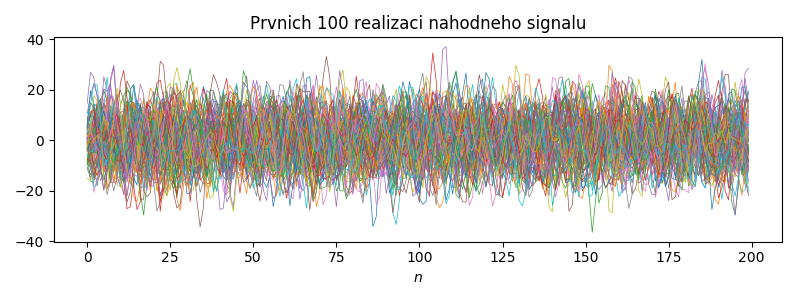

In [4]:
n_plot = 100 # pocet realizaci, ktere si vykreslime

plt.figure(figsize=(8,3))
plt.plot(ksi[:n_plot].T, linewidth=0.5)
plt.gca().set_title(f'Prvnich {n_plot} realizaci nahodneho signalu')
plt.gca().set_xlabel('$n$')

plt.tight_layout()


## Odhad distribuční funkce

Souborové odhady budeme dělat pro určitý čas $n$, v našem případě $n = 50$. Distribuční funkce $F(x,n)$ v zásadě odpovídá na otázku  _jak je pravděpodobné, že hodnota mého signálu pro vzorek $n$ bude menší než nějaká hodnota $x$_. Její hodnotu pro určité $x$ tedy odhadneme tak, že spočítáme v kolika realizacích byla hodnota signálu v čase $n$ menší než $x$ a tento počet podělíme celkovým počtem realizací. Odhad funkce spočítáme pro $x$, které se pohybují mezi minimální a maximální hodnotou našeho signálu v daném čase (pro menší $x$ je distribuční funkce nulová, pro větší $x$ má hodnotu 1). Spojitý průběh funkce aproximujeme pomocí 50 hodnot, pravidelně rozmístěných mezi minimum a maximum.

In [5]:
xmin = np.min(ksi)
xmax = np.max(ksi)
n_aprx = 50 # pocet hodnot, kterymi aproximujeme dist fci
x = np.linspace(xmin, xmax, n_aprx)

In [6]:
n = 50 # cas, pro ktery pocitame dist fci
Fx = np.zeros(x.shape)

for i in range(n_aprx):
    Fx[i] = np.sum(ksi[:,n] < x[i]) / Om

<IPython.core.display.Javascript object>


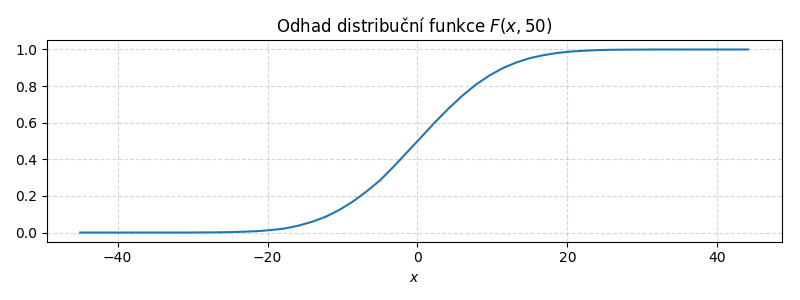

In [7]:
plt.figure(figsize=(8,3))
plt.plot(x, Fx)
plt.gca().set_xlabel('$x$')
plt.gca().set_title(f'Odhad distribuční funkce $F(x,{n})$')

plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()

## Odhad funkce hustoty rozdělení pravděpodobnosti

Funkce hustoty rozdělení pravděpodobnosti $p(x,n)$ je derivací distribuční funkce $F(x,n)$. Její hodnoty jsou nezáporné a platí, že integrál této funkce přes interval $<a,b>$ odpovídá pravděpodobnosti, že hodnota signálu v čase $n$ je v tomto intervalu. Integrál přes celou funkci hustoty rozdělení pravděpodobnosti (od $-\infty$ po $\infty$) by tedy měl být roven 1. 

Souborový odhad pro čas $n=50$ můžeme udělat pomocí histogramu. Budeme opět uvažovat $x$ z intervalu od minima po maximum našeho signálu a opět provedeme aproximaci funkce, rozdělením intervalu do diskrétních úseků. Pro každý úsek spočítáme, v kolika realizacích hodnota signálu v čase $n$ spadá do daného úseku. Tímto získáme histogram hodnot - v Pythonu za nás tento výpočet udělá funkce `numpy.histogram`. Abychom z histogramu dostali funkci $p(x,n)$, musíme jej podělit počtem realizací a velikostí jednoho úseku.

In [8]:
binsize = np.abs(x[1] - x[0])
hist, _ = np.histogram(ksi[:,n], n_aprx)
px = hist / Om / binsize

<IPython.core.display.Javascript object>


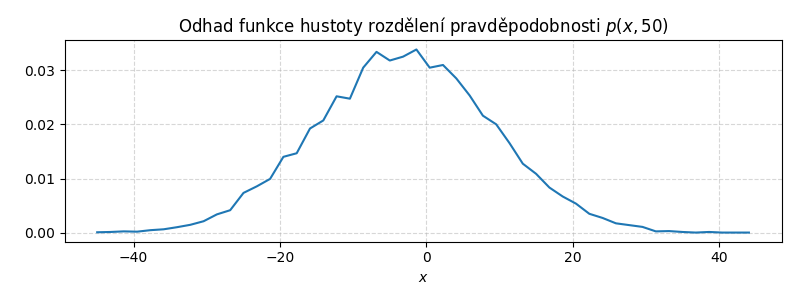

In [9]:
plt.figure(figsize=(8,3))
plt.plot(x, px)
plt.gca().set_xlabel('$x$')
plt.gca().set_title(f'Odhad funkce hustoty rozdělení pravděpodobnosti $p(x,{n})$')

plt.gca().grid(alpha=0.5, linestyle='--')

plt.tight_layout()

In [10]:
# integruje p(x,n) do 1?
np.sum(px * binsize)

0.99999999999999989

## Střední hodnota, směrodatná odchylka

Souborový odhad střední hodnoty a směrodatné odchylky spočítáme pro každý čas $n$ a vykreslíme si v závislosti na čase.

In [11]:
# pruměrujeme přes realizace (osa 0 matice ksi)
an = np.mean(ksi, axis=0)
stdn = np.std(ksi, axis=0)

<IPython.core.display.Javascript object>


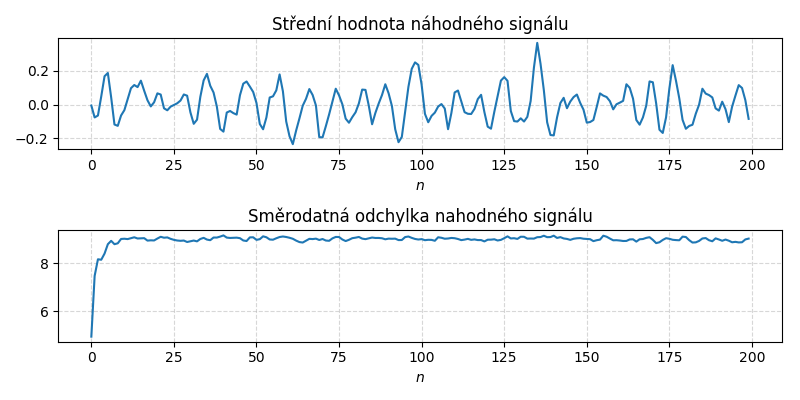

In [12]:
_, ax = plt.subplots(2,1, figsize=(8,4))

ax[0].plot(an)
ax[0].set_title('Střední hodnota náhodného signálu')
ax[0].set_xlabel('$n$')

ax[1].plot(stdn)
ax[1].set_title('Směrodatná odchylka nahodného signálu')
ax[1].set_xlabel('$n$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

## Funkce hustoty rozdělení pravděpodobnosti mezi dvěma časy, autokorelační koeficienty

Funkce hustoty rozdělení pravděpodobnosti mezi dvěma časy $p(x_1, x_2, n_1, n_2)$ popisuje vztah hodnot signálu v čase $n_1$ a $n_2$. Integrál této sdružené funkce přes intervaly $x_1 \in <a_1, b_1>$, $x_2 \in <a_2, b_2>$ odpovídá pravděpodobnosti, že hodnota signálu v čase $n_1$ spadá do intervalu $<a_1, b_1>$ a zároveň hodnota $x_2$ spadá do intervalu $<a_2, b_2>$. Odhad této funkce můžeme opět udělat pomocí histogramu - tentokrát 2D histogramu. V Pythonu jej spočítá funkce `numpy.histogram2d`. Výsledný histogram můžeme opět vydělit počtem realizací a velikostí jednoho úseku (tentokrát 2D úseku), abychom získali odhad funkce $p(x_1, x_2, n_1, n_2)$. Druhá možnost je použít parametr `normed=True`, který histogram vynormalizuje za nás.

Autokorelační koeficient $R(n_1,n_2)$ udává míru toho, jak je _signál sám sobě podobný mezi časy $n_1$ a $n_2$_. Vypočteme jej z funkce hustoty rozdělení pravděpodobnosti jako:

$$
R(n_1, n_2) = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} x_1 x_2 p(x_1,x_2, n_1, n_2) dx_1 dx_2.
$$

Prakticky tento integrál v Pythonu můžeme spočítat následovně:
* $p(x_1, x_2, n_1, n_2)$ spočítáme pomocí 2D histogramu, jak naznačeno výše, výsledkem bude matice hodnot
* vytvoříme matici součinů středu jednotlivých úseků $x_1$, $x_2$, nad kterými byl spočítán histogram. Nejjednodušeji toto můžeme udělat pomocí outer produktu vektorů těchto středů
* tyto dvě matice prvek po prvku vynásobíme
* samotný integrál pak získáme jako součet hodnot v matici vynásobený obsahem jednotlivých 2D úseků

Ukážeme si příklad pro $n_1=50$ a různé hodnoty $n_2$ od $50$ do $69$.

In [13]:
n1 = 50

px1x2_all = [] # pole funkci hustoty rozdeleni pravdepodobnosti
x1e_all = []   # pole hranic jednotlivych useku, na kterych aproximujeme hodnotu x_1
x2e_all = []   # pole hranic jednotlivych useku, na kterych aproximujeme hodnotu x_2
R_all = []     # pole vypocitanych autokorelacnich koeficientu
int_all = []   # pole integralu p(x1,x2,n1,n2) - melo by byt vzdy rovno 1

for n2 in range(n1, n1 + 20):
    px1x2, x1_edges, x2_edges = np.histogram2d(ksi[:,n1], ksi[:,n2], n_aprx, normed=True)
    px1x2_all.append(px1x2)
    x1e_all.append(x1_edges)
    x2e_all.append(x2_edges)
    
    # integral p(x1, x2, n1, n2), mel by vyjit 1
    binsize = np.abs(x1_edges[0] - x1_edges[1]) * np.abs(x2_edges[0] - x2_edges[1])
    integral = np.sum(px1x2 * binsize)
    int_all.append(integral)
    
    # autokorelacni koeficient
    bin_centers_x1 = x1_edges[:-1] + (x1_edges[1:] - x1_edges[:-1]) / 2
    bin_centers_x2 = x2_edges[:-1] + (x2_edges[1:] - x2_edges[:-1]) / 2
    x1x2 = np.outer(bin_centers_x1, bin_centers_x2)
    R = np.sum(x1x2 * px1x2 * binsize)
    R_all.append(R)

# alternativa vypoctu px1x2 s rucni normalizaci misto parametru normed
# hist, x1_edges, x2_edges = np.histogram2d(ksi[:,n1], ksi[:,n2], n_aprx)
# binsize = np.abs(x1_edges[0] - x1_edges[1]) * np.abs(x2_edges[0] - x2_edges[1])
# px1x2 = hist / binsize / Om

<IPython.core.display.Javascript object>


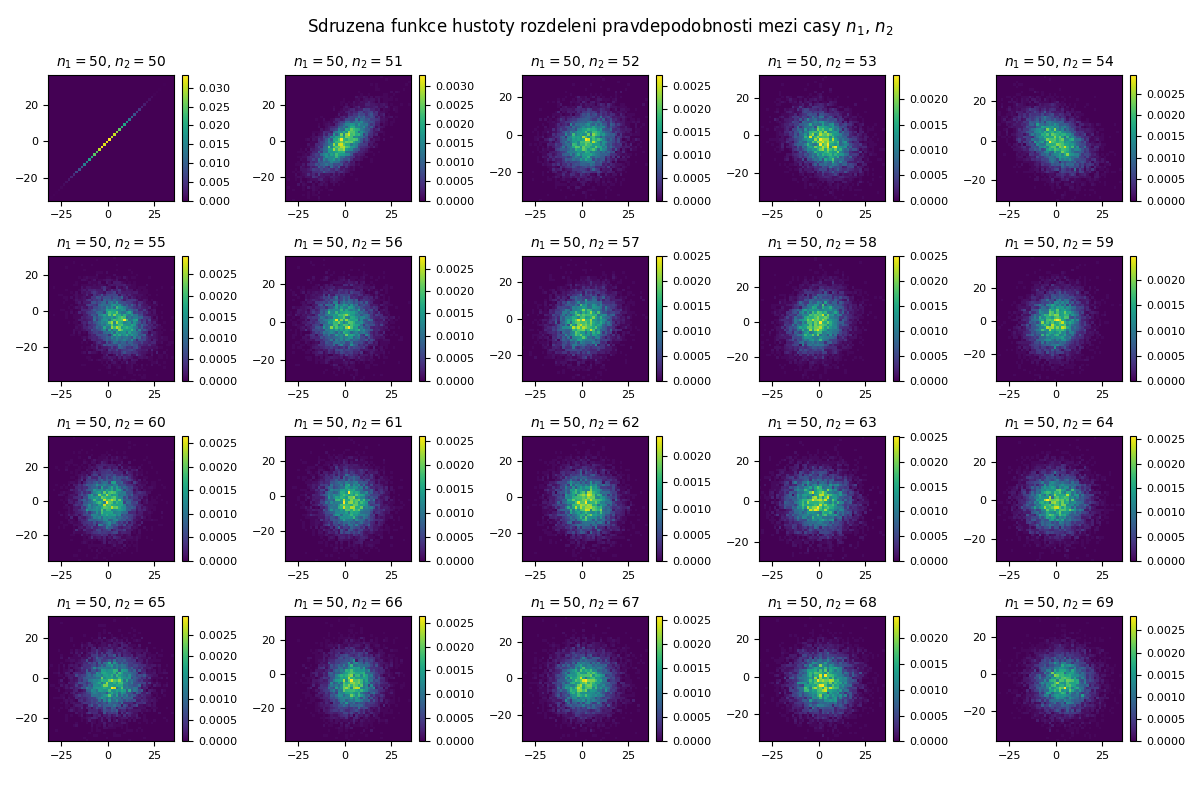

In [14]:
_, ax = plt.subplots(4,5,figsize = (12,8))

for i in range(20):
    n2 = n1 + i
    
    X, Y = np.meshgrid(x1e_all[i], x2e_all[i])
    im = ax[i//5][i%5].pcolormesh(X, Y, px1x2_all[i])
    
    ax[i//5][i%5].set_title(f'$n_1 = {n1}$, $n_2 = {n2}$', fontsize=10)
    cbar = plt.colorbar(im, ax = ax[i//5][i%5])
    
    cbar.ax.tick_params(labelsize=8) 
    ax[i//5][i%5].tick_params(labelsize=8)

plt.suptitle('Sdruzena funkce hustoty rozdeleni pravdepodobnosti mezi casy $n_1$, $n_2$')    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
# integruji sdruzene funkce hustoty do 1?
print(int_all)

[0.99999999999999944, 0.99999999999999845, 0.999999999999998, 0.99999999999999822, 0.99999999999999822, 1.0000000000000007, 1.0, 0.99999999999999778, 0.99999999999999845, 0.99999999999999822, 0.99999999999999811, 0.99999999999999778, 1.0000000000000009, 0.99999999999999911, 0.99999999999999911, 1.0000000000000002, 1.0000000000000011, 1.0, 0.99999999999999833, 0.99999999999999845]


In [16]:
# hodnoty autokorelacnich koeficientu
print(R_all)

[80.490471198827009, 54.638354437972382, 10.437798376970798, -22.904673024414514, -32.673378053462898, -21.193467851099175, -2.9475682801179897, 10.312870845394805, 13.842963779694351, 8.8731775359862191, 0.85083877952051978, -4.7335214602446225, -6.5255814814615638, -3.8881185664753835, -0.62721294793618398, 1.7712204383031249, 2.2824872366066504, 1.2926863672097308, -0.19718397467911192, -0.79971402103581912]


# Časové odhady

## Generování náhodného procesu

Budeme používat stejný náhodný proces jako v minulé části projektu, tedy
gaussovský šum prošlý filtrem

$$
H(z) = \frac{1}{1+    -1.1314 z^{-1} +    0.6400z^{-2}},
$$

ale vygenerujeme jen jednu realizaci, která bude dostatečně dlouhá: 10000 vzorků.

In [17]:
N = 10000

mean = 0
std = 5

b = [1, 0, 0]
a = [1, -1.1314, 0.6400]

x = np.random.normal(mean, std, N)
ksi = lfilter(b, a, x)

<IPython.core.display.Javascript object>


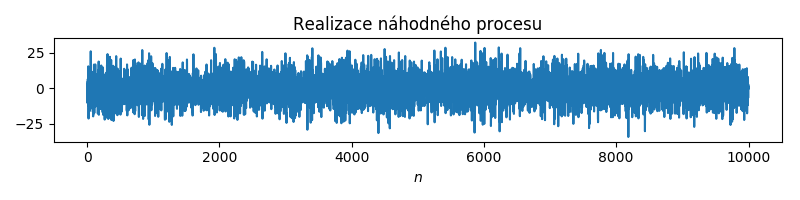

In [18]:
plt.figure(figsize=(8,2))
plt.gca().set_title('Realizace náhodného procesu')
plt.gca().set_xlabel('$n$')
plt.plot(ksi)

plt.tight_layout()

## Odhad střední hodnoty a směrodatné odchylky

Narozdíl od souborového odhadu, kde jsme odhady počítali průměrováním přes všechny realizace, u časového odhadu budeme průměrovat přes čas v rámci jedné realizace.

In [19]:
a = np.mean(ksi)
sigma = np.std(ksi)

In [20]:
a, sigma

(0.0059643428025772469, 9.0323563550786474)

## Odhad distribuční funkce a funkce hustoty rozdělení pravděpodobnosti

Opět spočítáme analogicky k souborovým odhadům, ale místo toho, abychom dělali odhad pro daný čas, přes všechny realizace, budeme odhadovat přes všechny časy v rámci jedné realizace.

In [21]:
xmin = np.min(ksi)
xmax = np.max(ksi)
n_aprx = 50 # pocet hodnot, kterymi aproximujeme dist fci
x = np.linspace(xmin, xmax, n_aprx)

In [22]:
Fx = np.zeros(x.shape)

for i in range(n_aprx):
    xx = x[i]
    Fx[i] = np.sum(ksi < xx) / N

<IPython.core.display.Javascript object>


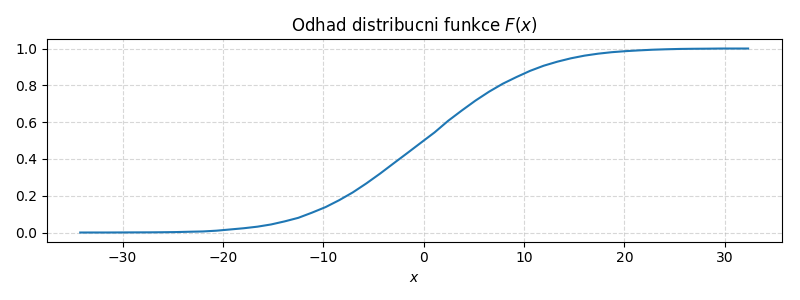

In [23]:
plt.figure(figsize=(8,3))
plt.plot(x, Fx)
plt.gca().set_xlabel('$x$')
plt.gca().set_title(f'Odhad distribucni funkce $F(x)$')

plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()

In [24]:
binsize = np.abs(x[1] - x[0])
hist, _ = np.histogram(ksi, n_aprx)
px = hist / N / binsize

<IPython.core.display.Javascript object>


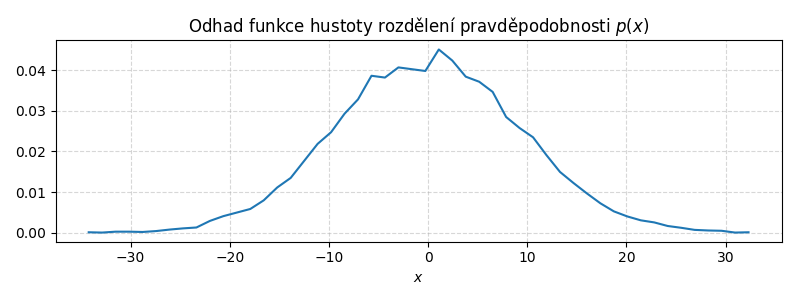

In [25]:
plt.figure(figsize=(8,3))
plt.plot(x, px)
plt.gca().set_xlabel('$x$')
plt.gca().set_title(f'Odhad funkce hustoty rozdělení pravděpodobnosti $p(x)$')

plt.gca().grid(alpha=0.5, linestyle='--')

plt.tight_layout()

In [26]:
# integruje p(x) do 1?
np.sum(px * binsize)

1.0

## Odhad autokorelačních koeficientů

Zatímco u souborových odhadů jsme počítali autokorelační koeficienty mezi dvěma konkrétními časy $n_1$, $n_2$, u časového odhadu budeme počítat autokorelační koeficient mezi všemi dvojicemi časů, které jsou vzdálené $k$. Autokorelační koeficient tu tedy udává míru toho _jak si je signál podobný v čase n a čase n+k_. Odhad bychom opět mohli udělat ze sdružené funkce hustoty rozdělení pravděpodobnosti $p(x_1, x_2, k)$ - časový odhad této funkce bychom udělali analogicky k souborovému odhadu, ale místo hodnot signálu v časech $n_1$ a $n_2$ přes všechny realizace bychom použili hodnoty signálu v časech $n$ a $n+k$ přes všechny časy $n$.

Autokorelační koeficienty můžeme ale odhadnout i přímo, bez funkce hustoty rozdělení pravděpodobnosti, násobením hodnot signálu v čase $n$ a $n+k$ a průměrem přes všechny časy $n$. Rozlišujeme tzv. vychýlený odhad $R_v(k)$ a nevychýlený odhad $R_{nv}(k)$ podle toho, zda dělíme celkovým počtem vzorků nebo jen počtem vzorků, kde se $x[n]$ a $x[n+k]$ překrývají:

$$
\hat{R}_v(k) = \frac{1}{N} \sum_{n=0}^{N-1} x[n]x[n+k],~~~~~~\hat{R}_{nv}(k) = \frac{1}{N-|k|} \sum_{n=0}^{N-1} x[n]x[n+k],
$$

V Pythonu můžeme použít například funkci `numpy.correlate` a výsledek vhodně normalizovat.

In [27]:
k = np.arange(-N+1, N)
Rv = np.correlate(ksi, ksi, 'full') / N
Rnv = np.correlate(ksi, ksi, 'full') / (N - np.abs(k))

<IPython.core.display.Javascript object>


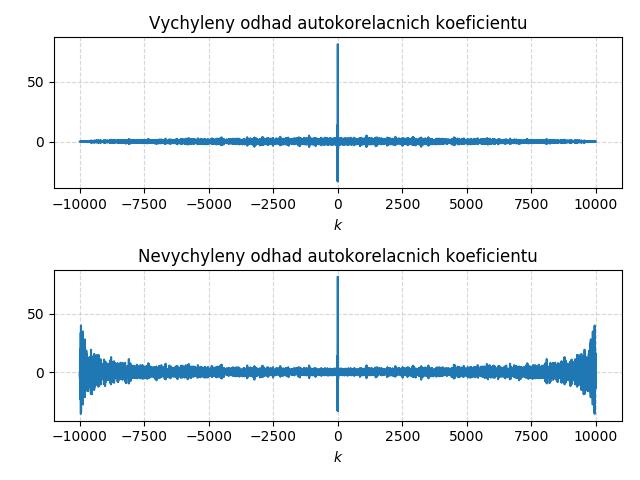

In [28]:
_, ax = plt.subplots(2,1)

ax[0].plot(k, Rv)
ax[0].set_title('Vychyleny odhad autokorelacnich koeficientu')
ax[0].set_xlabel('$k$')

ax[1].plot(k, Rnv)
ax[1].set_title('Nevychyleny odhad autokorelacnich koeficientu')
ax[1].set_xlabel('$k$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

# Spektra

Na závěr se podíváme na to, jak odhadnout spektrální hustotu výkonu (PSD) náhodného signálu a jak se PSD změní po průchodu signálu filtrem.

## Spektrální hustota výkonu - power spectral density (PSD)

Budeme ji odhadovat pomocí DFT z celé realizace nebo průměrováním přes několik segmentů  (vztahy viz. přednáška, slajdy 14 a 15). Průměrování by mělo vést k hladšímu odhadu.

In [29]:
# odhad z cele realizace
G_dft = 1/N * np.abs(np.fft.fft(ksi))**2
w_dft = np.linspace(0, 2*np.pi, G_dft.size)

In [30]:
# odhad prumerovanim pres nekolik segmentu
n_per_seg = 100
ksi_resh = np.reshape(ksi, (-1, n_per_seg))
G_per_seg = np.abs(np.fft.fft(ksi_resh))**2 / n_per_seg
G_prum = np.mean(G_per_seg, axis = 0)
w_prum = np.linspace(0, 2*np.pi, G_prum.size)

<IPython.core.display.Javascript object>


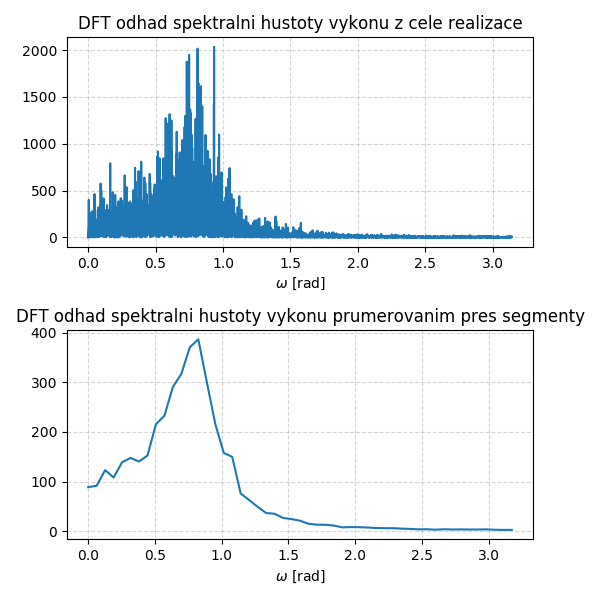

In [31]:
_, ax = plt.subplots(2, 1, figsize=(6,6))

ax[0].plot(w_dft[:w_dft.size//2+1], G_dft[:G_dft.size//2+1])
ax[0].set_xlabel('$\omega$ [rad]')
ax[0].set_title('DFT odhad spektralni hustoty vykonu z cele realizace')

ax[1].plot(w_prum[:w_prum.size//2+1], G_prum[:G_prum.size//2+1])
ax[1].set_xlabel('$\omega$ [rad]')
ax[1].set_title('DFT odhad spektralni hustoty vykonu prumerovanim pres segmenty')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

## Průchod náhodného signálu lineárním systémem

Necháme náš náhodný signál projít filtrem s přenosovou funkcí:

$$
H(z) = {1    -1.1314 z^{-1} +    0.6400z^{-2}}
$$

(všimněte si, že to je inverzní  filtr k tomu, který jsme použili na začátku).  Spektrální hustota výkonu  na výstupu by měla být: 

$$
G_y(e^{j\omega}) = |H(e^{j\omega})|^2  G_x(e^{j\omega}),
$$

což se pokusíme ověřit.

In [32]:
# zadani filtru
a = [1, 0, 0]
b = [1, -1.1314, 0.64]

# frekvencni charakteristika
w, H = freqz(b, a, 51)
H2 = np.abs(H)**2

# filtrovani
y = lfilter(b, a, ksi)

In [33]:
# spektralni hustota vykonu vystupniho signalu
# odhad prumerovanim pres nekolik segmentu
n_per_seg = 100
y_resh = np.reshape(y, (-1, n_per_seg))
Gy_per_seg = np.abs(np.fft.fft(y_resh))**2 / n_per_seg
Gy_prum = np.mean(Gy_per_seg, axis = 0)

<IPython.core.display.Javascript object>


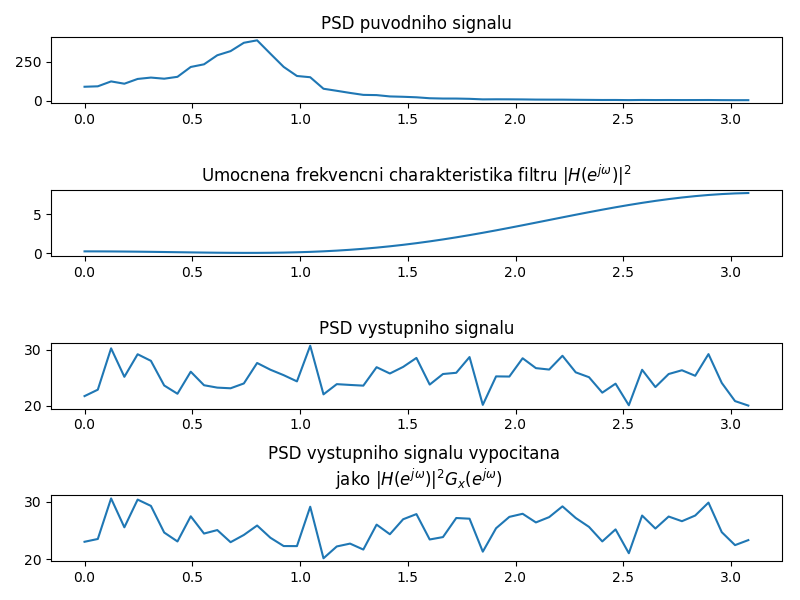

In [34]:
_, ax = plt.subplots(4,1, figsize=(8,6))

ax[0].plot(w, G_prum[:G_prum.size//2+1])
ax[0].set_title('PSD puvodniho signalu')
ax[1].plot(w, H2)
ax[1].set_title('Umocnena frekvencni charakteristika filtru $|H(e^{j\omega})|^2$')
ax[2].plot(w, Gy_prum[:Gy_prum.size//2+1])
ax[2].set_title('PSD vystupniho signalu')
ax[3].plot(w, G_prum[:Gy_prum.size//2+1] * H2)
ax[3].set_title('PSD vystupniho signalu vypocitana \n jako $|H(e^{j\omega})|^2 G_x(e^{j\omega})$')

plt.tight_layout()